In [1]:
import collections
import seaborn as sns
import os
import glob
import numpy as np
from sklearn.decomposition import PCA
import math
import re
import pandas as pd
import nltk
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

Автоматический поиск произведений в папках texts/txt/\*\* (вместо \*\* — имя автора) и создание словарей *название-путь\_к\_файлу* (TITLE_PATH_DICT), *название-автор* (TITLE_AUTHOR_DICT), *автор-множество\_названий\_произведений* (AUTHOR__TITLE_SET__DICT).

In [2]:
FILE_PATHS = glob.glob('texts/converted/**/*.txt', recursive=True)

In [3]:
TITLE_PATH_DICT = {path.split("\\")[-1].split(".")[0] : path for path in FILE_PATHS}
TITLE_AUTHOR_DICT = {path.split("\\")[-1].split(".")[0] : path.split("\\")[-2] for path in FILE_PATHS}

In [4]:
AUTHOR__TITLE_SET__DICT = collections.defaultdict(set)
for title, author in TITLE_AUTHOR_DICT.items():
    AUTHOR__TITLE_SET__DICT[author].add(title)
AUTHOR__TITLE_SET__DICT = dict(AUTHOR__TITLE_SET__DICT)

In [5]:
NPY_FOLDER = 'texts/5000_words_lemmatized/'

## Подсчет слов и t-SNE

In [6]:
corpus_word_counter = collections.defaultdict(int)
npy_paths = glob.glob(f'{NPY_FOLDER}/**/*.npy', recursive=True)
for npy_path in tqdm(npy_paths):
    lemmas = np.load(npy_path)
    for lemma in lemmas:
        corpus_word_counter[lemma] += 1
corpus_word_counter_lst_sorted = sorted(list(corpus_word_counter.items()), key=lambda x: -x[1])
corpus_word_counter = dict(corpus_word_counter)

100%|███████████████████████████████████████████████████████████████████████████████| 971/971 [00:02<00:00, 334.48it/s]


In [7]:
corpus_word_counter_lst_sorted[:10]

[('и', 211937),
 ('он', 129283),
 ('в', 117920),
 ('не', 106346),
 ('я', 103086),
 ('что', 92002),
 ('она', 72541),
 ('на', 69040),
 ('с', 66380),
 ('быть', 65391)]

In [8]:
def make_word_count_df(n_top_words=2000, excerpt_mul=1):
    corpus_word_counter_lst_sorted_short = corpus_word_counter_lst_sorted[:n_top_words]
    columns=['author'] + [word for word, _ in corpus_word_counter_lst_sorted_short]

    df_npy_word_count = pd.DataFrame(columns=columns)

    num_of_npys = len(glob.glob(f'{NPY_FOLDER}/**/*.npy', recursive=True))
    with tqdm(total=num_of_npys) as pbar:
        for author in AUTHOR__TITLE_SET__DICT.keys():
            npy_paths = glob.glob(f'{NPY_FOLDER}/{author}/*.npy', recursive=True)
            for i in range(0, len(npy_paths), excerpt_mul):
                book_word_counter = collections.defaultdict(int)
                lemmas = []
                for npy_path in npy_paths[i:i+excerpt_mul]:
                    lemmas = np.concatenate([lemmas, np.load(npy_path)])
                for lemma in lemmas:
                    book_word_counter[lemma] += 1
                tmp_df = pd.DataFrame(
                    [[author] + [book_word_counter[lemma] / len(lemmas) for lemma, _ in corpus_word_counter_lst_sorted_short]], 
                    columns=columns
                )
                df_npy_word_count = pd.concat([df_npy_word_count, tmp_df], ignore_index=True)
                pbar.update(excerpt_mul)
    return df_npy_word_count

In [9]:
def word_count_tsne(n_top_words=2000, excerpt_mul=1, info=""):
    df_npy_word_count = make_word_count_df(n_top_words, excerpt_mul)
    
    df_npy_word_count_no_author = df_npy_word_count.copy()
    df_author_only = df_npy_word_count_no_author.pop("author")
    
    tsne = TSNE(n_components=2, learning_rate=100, random_state=273)
    tsne_results = tsne.fit_transform(df_npy_word_count_no_author)

    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne["label"] = df_author_only
    
    sns.lmplot(x="comp1", y="comp2", data=df_tsne, hue="label", fit_reg=False)
    plt.title(f"{info}\nТоп-{n_top_words} слов. Длина отрывков {5000*excerpt_mul} слов.")
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 971/971 [00:06<00:00, 152.43it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


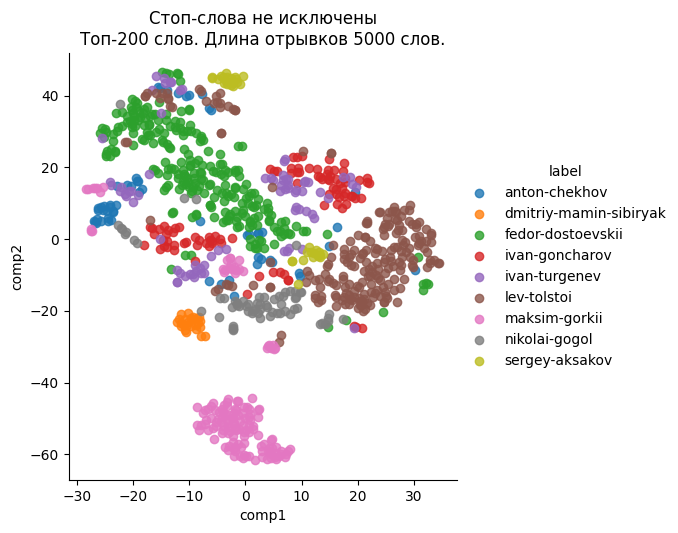

100%|████████████████████████████████████████████████████████████████████████████████| 971/971 [00:21<00:00, 44.34it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


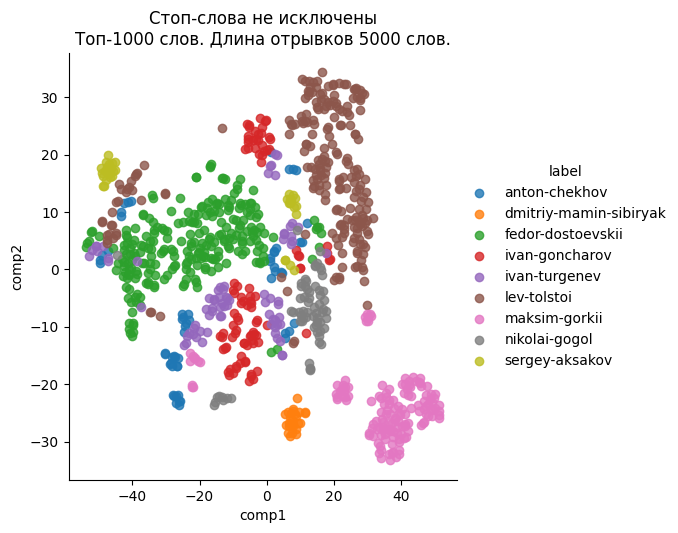

100%|████████████████████████████████████████████████████████████████████████████████| 971/971 [00:40<00:00, 24.05it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


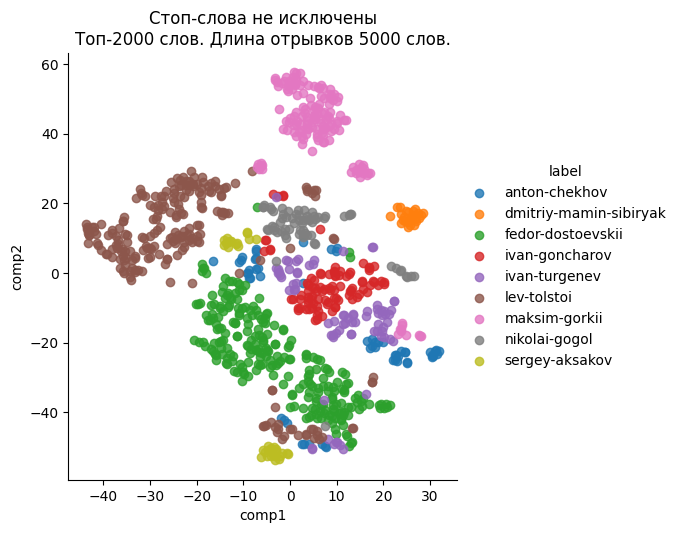

974it [00:12, 78.66it/s]                                                                                               
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


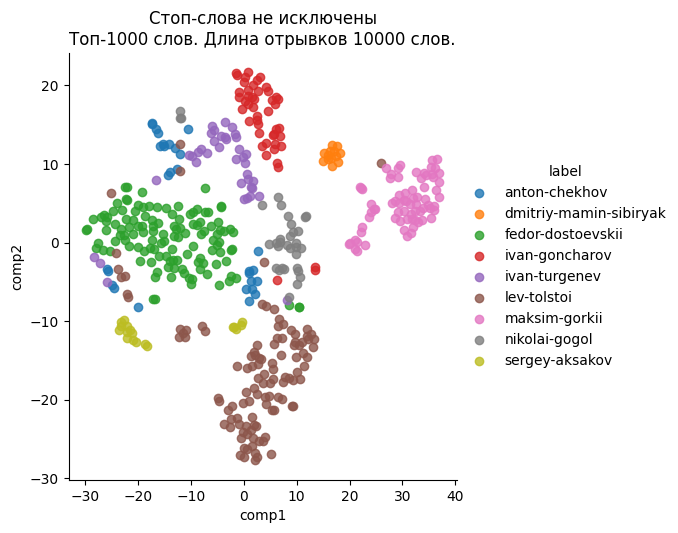

974it [00:21, 45.26it/s]                                                                                               
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


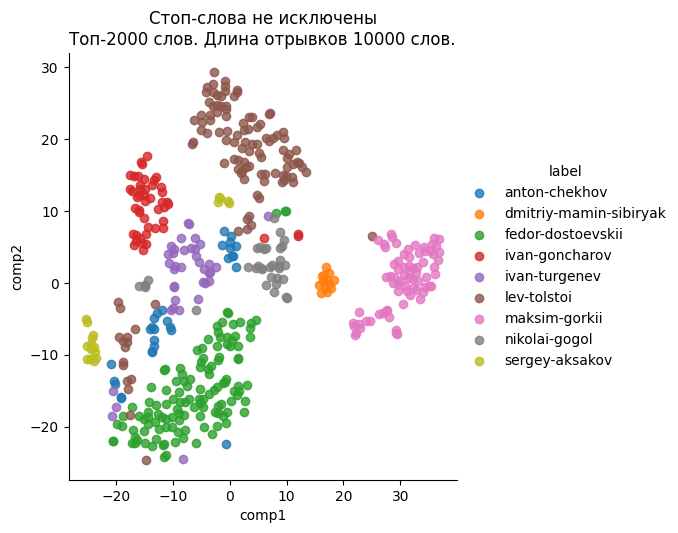

988it [00:04, 222.27it/s]                                                                                              
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


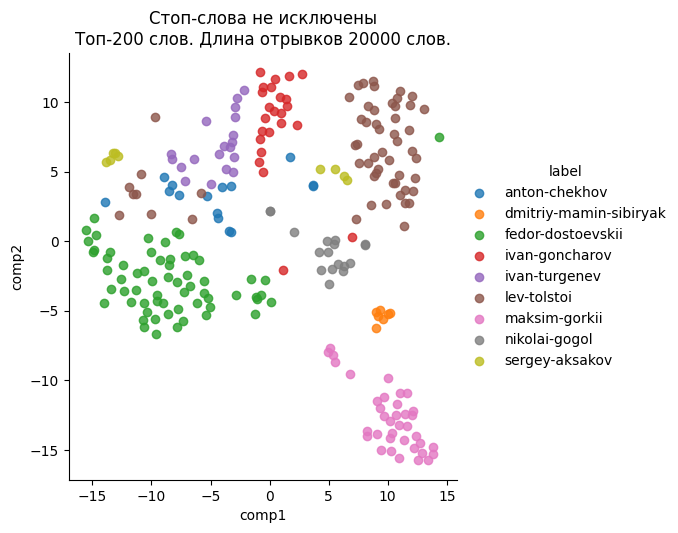

988it [00:12, 77.90it/s]                                                                                               
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


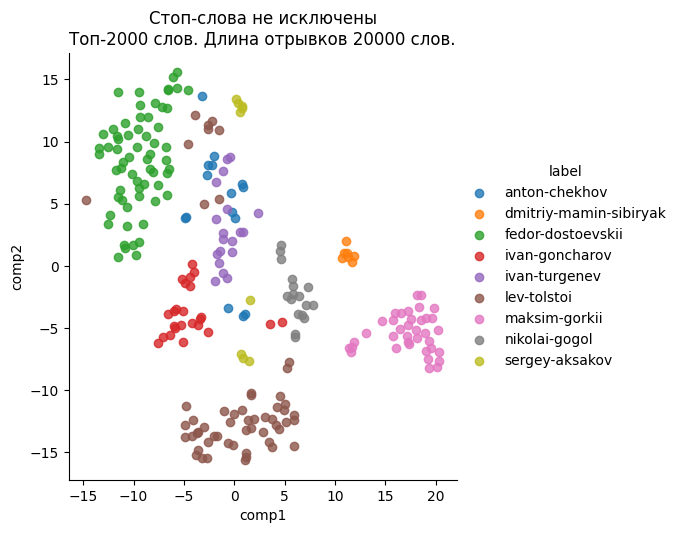

In [10]:
variants = [(200, 1), (1000, 1), (2000, 1), (1000, 2), (2000, 2), (200, 4), (2000, 4)]
for n_top_words, excerpt_mul in variants:
    word_count_tsne(n_top_words, excerpt_mul, info="Стоп-слова не исключены")

## Подсчет слов и t-SNE без стоп-слов

In [11]:
from nltk.corpus import stopwords

In [12]:
new_corpus_word_counter = dict()
for key, val in tqdm(corpus_word_counter.items()):
    if key not in stopwords.words('russian'):
        new_corpus_word_counter[key] = val
corpus_word_counter = new_corpus_word_counter
corpus_word_counter_lst_sorted = sorted(list(corpus_word_counter.items()), key=lambda x: -x[1])

100%|██████████████████████████████████████████████████████████████████████████| 59051/59051 [00:11<00:00, 5116.63it/s]


In [13]:
corpus_word_counter_lst_sorted[:10]

[('это', 43386),
 ('всё', 32425),
 ('сказать', 25386),
 ('свой', 24895),
 ('который', 20815),
 ('говорить', 19567),
 ('весь', 19410),
 ('человек', 18279),
 ('мочь', 17826),
 ('знать', 15643)]

100%|███████████████████████████████████████████████████████████████████████████████| 971/971 [00:07<00:00, 137.46it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


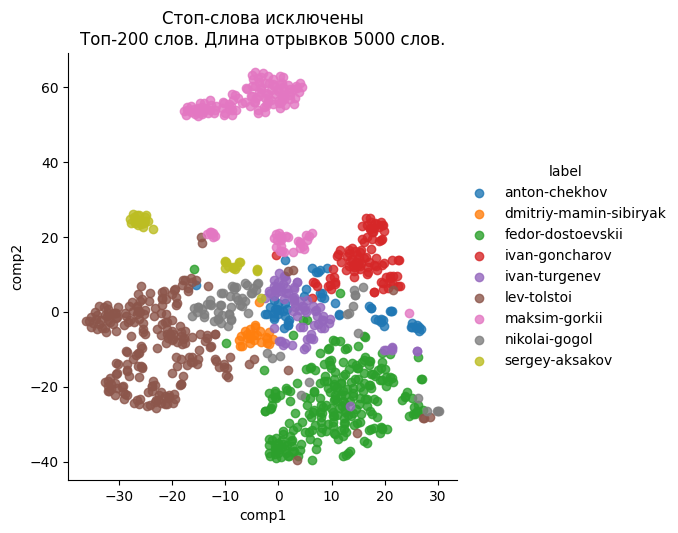

100%|████████████████████████████████████████████████████████████████████████████████| 971/971 [00:21<00:00, 44.25it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


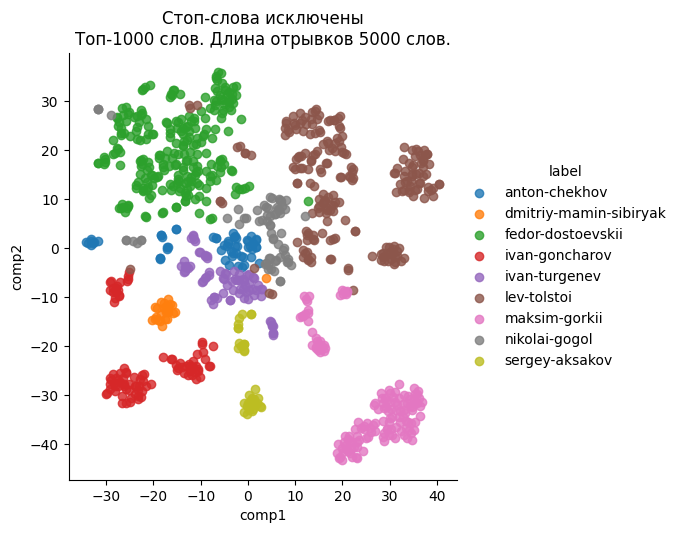

100%|████████████████████████████████████████████████████████████████████████████████| 971/971 [00:40<00:00, 24.08it/s]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


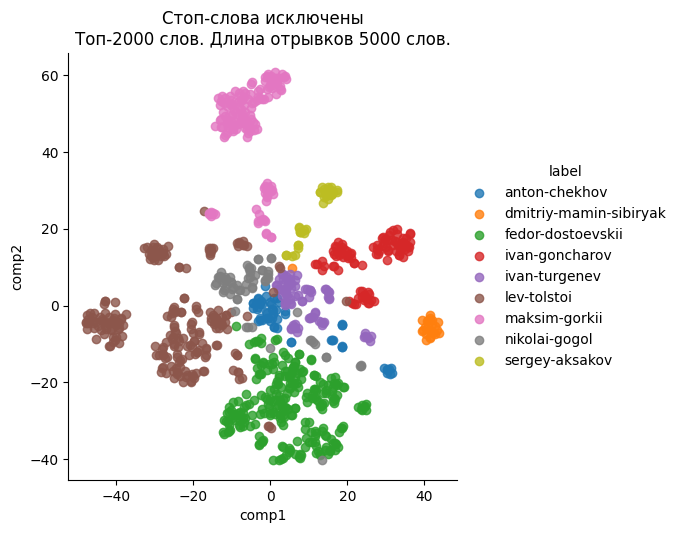

974it [00:12, 77.28it/s]                                                                                               
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


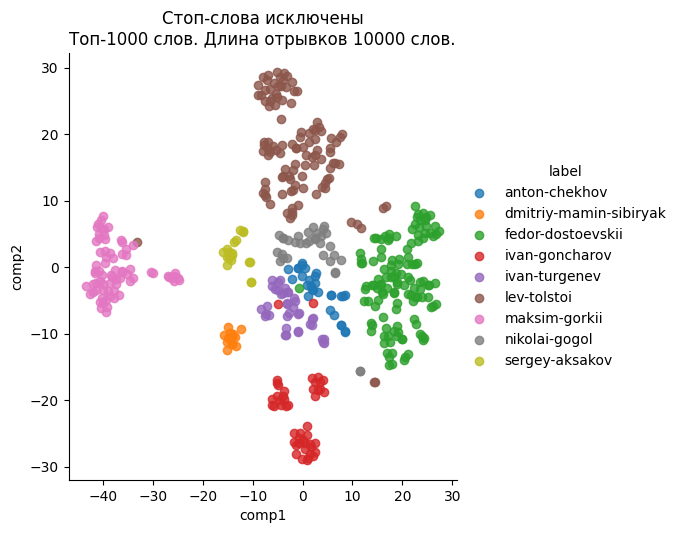

974it [00:20, 46.52it/s]                                                                                               
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


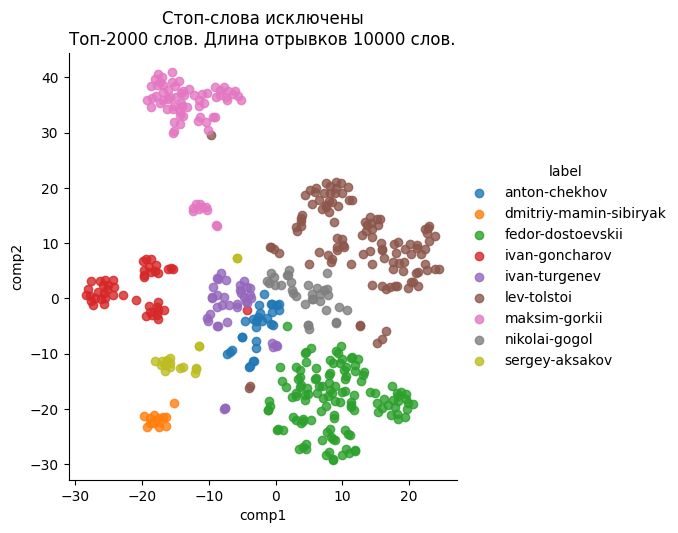

988it [00:04, 229.77it/s]                                                                                              
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


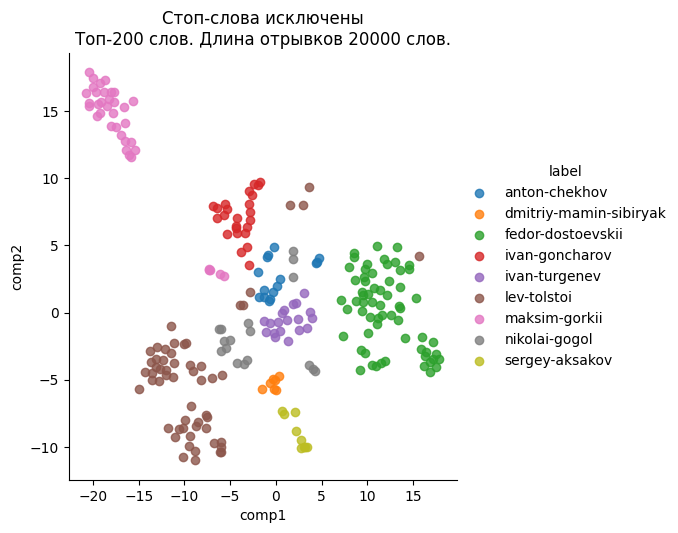

988it [00:12, 77.82it/s]                                                                                               
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str_']. An error will be raised in 1.2.
  warnings.warn(


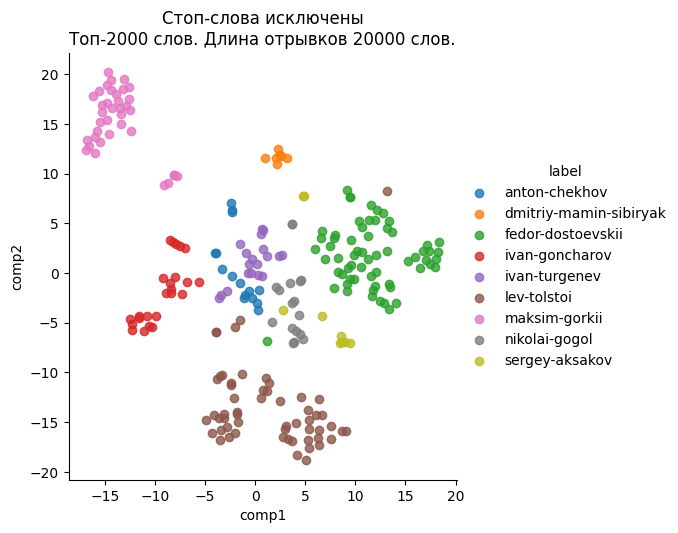

In [14]:
variants = [(200, 1), (1000, 1), (2000, 1), (1000, 2), (2000, 2), (200, 4), (2000, 4)]
for n_top_words, excerpt_mul in variants:
    word_count_tsne(n_top_words, excerpt_mul, info="Стоп-слова исключены")